In [29]:
import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib.pylab as plt
import config as cf
import math

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from chinese_calendar import is_workday, is_holiday
from jupyterthemes import jtplot

jtplot.style()
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 200

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

第一步，预测品牌合计算结果

In [30]:
train_df = pd.read_csv(cf.fusai_train_file_path, sep='\t')
# A
testA_df = pd.read_csv(cf.fusai_testA_file_path, sep='\t')
# B
testB_df = pd.read_csv(cf.fusai_testB_file_path, sep='\t')
test_df = testB_df
test_all_df = test_df[['date', 'day_of_week']].drop_duplicates()
# answer A as train data
trainA_df = pd.read_csv(cf.fusai_answerA_file_path, sep='\t', header=None, names=['date', 'brand', 'cnt'])
trainA_df = testA_df.merge(trainA_df)
train_df = train_df.append(trainA_df)

In [31]:
def fix_data_date(df, last_dow, start_date):
    fix_rows = []
    fix_date = 0
    fix_columns = np.append(df.columns.values, 'date_fix')
    is_train = 'cnt' in fix_columns
    for i, row in df.iterrows():
        curr_dow = row['day_of_week']
        while curr_dow - last_dow > 1 or -6 < curr_dow - last_dow <= 0:
            last_dow = last_dow + 1 if last_dow < 7 else 1
            fix_date += 1
            if is_train:
                fix_rows.append(np.array([-1, 0, last_dow, start_date + timedelta(days=fix_date)]))
            else:
                fix_rows.append(np.array([-1, last_dow, start_date + timedelta(days=fix_date)]))
        last_dow = curr_dow
        fix_date += 1
        fix_rows.append(np.append(row.values, start_date + timedelta(days=fix_date)))
    new_df = pd.DataFrame(fix_rows, columns=fix_columns)
    return new_df

# process train date
start_train_date = datetime(2012,12,31)
train_cnt_df = train_df.groupby('date', as_index=False)['cnt'].sum()
train_cnt_df = train_cnt_df.merge(train_df[['date', 'day_of_week']].drop_duplicates(), on='date')
train_new_df = fix_data_date(train_cnt_df, 1, start_train_date)
# process test date
start_test_date = train_new_df.iloc[-1,-1] - timedelta(days=1)
last_dow = train_new_df.iloc[-1,-2] - 1
test_new_df = fix_data_date(test_all_df, last_dow, start_test_date)

# test_new_df = test_new_df.append(pd.DataFrame([[-1,3,datetime(2017,11,29)]], columns=test_new_df.columns.values))
# test_new_df = test_new_df.append(pd.DataFrame([[-1,4,datetime(2017,11,30)]], columns=test_new_df.columns.values))

##### 1. devide raw data into month trend and daily factor.

In [32]:
# process train data
train_new_df['month'] = train_new_df['date_fix'].map(lambda x:datetime(x.year,x.month,1))
train_fix_df = train_new_df.loc[train_new_df['month'] < '20161001']
frame_sum = train_fix_df.groupby('month')['cnt'].sum()
frame_sum.name = 'month_sum'
frame_days = train_fix_df.loc[train_fix_df['date']>0].groupby('month')['date'].count()
frame_days.name = 'month_days'
frame_mean = frame_sum / frame_days
frame_mean.name = 'month_mean'
train_fix_df = train_fix_df.merge(frame_sum.reset_index(), on='month')
train_fix_df = train_fix_df.merge(frame_days.reset_index(), on='month')
train_fix_df = train_fix_df.merge(frame_mean.reset_index(), on='month')
train_fix_df.to_csv(cf.train_fix_file_path)
train_fix_df.set_index('date_fix', inplace=True)
# process test data
test_new_df['month'] = test_new_df['date_fix'].map(lambda x:datetime(x.year,x.month,1))
test_fix_df = test_new_df
test_fix_df.to_csv(cf.test_fix_file_path)
frame_days = test_fix_df.loc[test_fix_df['date']>0].groupby('month')['date'].count()
frame_days.name = 'month_days'
# fix last day
# A
#frame_days[-1] = 21
test_fix_df = test_fix_df.merge(frame_days.reset_index(), on='month', how='left')
test_fix_df.set_index('date_fix', inplace=True)

##### 2. First Predict monthly trend

(-1.8620536803981527, 0.35011729746531645, 0, 32, {'5%': -2.9572185644531253, '1%': -3.653519805908203, '10%': -2.6175881640625001}, 84.187636283620378)


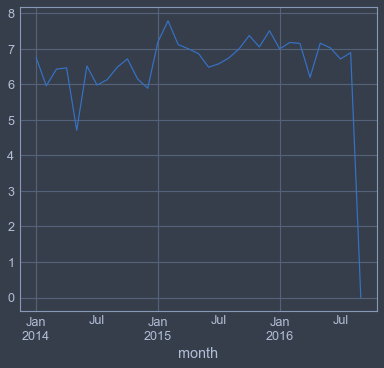

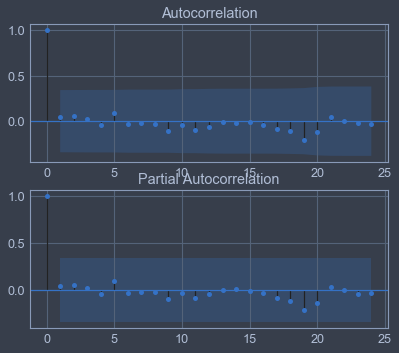

In [33]:
# 最后一月数据缺失
ts = frame_mean.diff(12)
# diff修正值
diff_plus = 1 - ts.min()
# deal with neg values and use log to reduce amplitude
ts = np.log(ts + diff_plus)
ts.dropna(inplace=True)
# fix sample with huge diff
#ts[4] = 6
#ts[13] = 7.0
#ts[32] = 5.8
ts.plot()

f = plt.figure()
ax1 = f.add_subplot(211)
plot_acf(ts, lags=24, ax=ax1)
ax2 = f.add_subplot(212)
plot_pacf(ts, lags=24, ax=ax2)

print adfuller(ts)

In [34]:
model = ARMA(ts, order=(6, 6)) 
result_arma = model.fit(disp=-1)
#result_arma.plot_predict(start='2014-08-01', ax=ax1)
print result_arma.summary()

                              ARMA Model Results                              
Dep. Variable:             month_mean   No. Observations:                   33
Model:                     ARMA(6, 6)   Log Likelihood                 -52.147
Method:                       css-mle   S.D. of innovations              0.999
Date:                Fri, 09 Mar 2018   AIC                            132.294
Time:                        19:13:17   BIC                            153.245
Sample:                    01-01-2014   HQIC                           139.344
                         - 09-01-2016                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.3059      0.441     14.297      0.000       5.441       7.170
ar.L1.month_mean    -0.0519      0.471     -0.110      0.913      -0.974       0.870
ar.L2.month_mean    -0.0430 

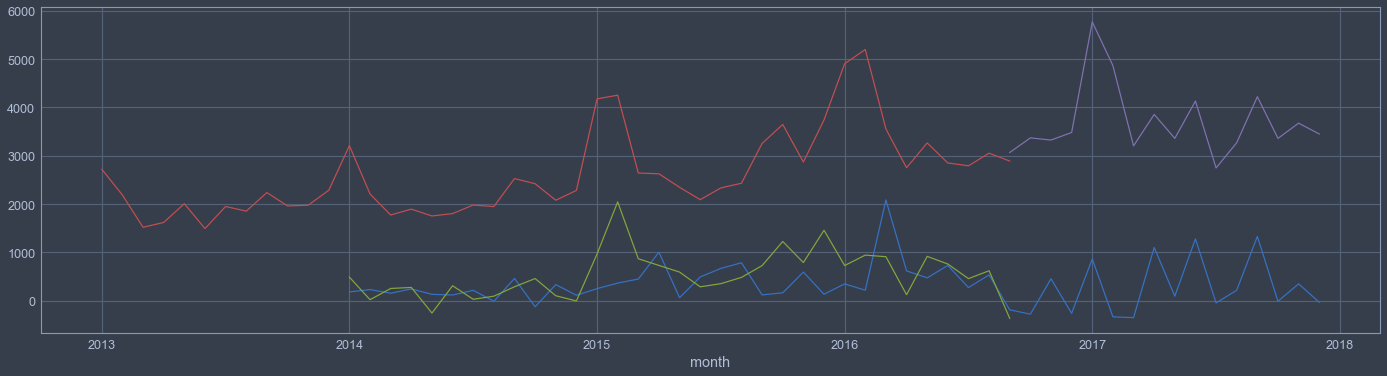

In [35]:
f = plt.figure(figsize=(24,6))
# recover predict value
predict_values = result_arma.predict(end='2017-12-1')
# log recover
predict_values = np.exp(predict_values) - diff_plus

predict_values.plot()
frame_mean.diff(12).plot()


frame_mean_ext = frame_mean.append(pd.Series(index=pd.date_range('2016-10','2017-09',freq='MS')))
# calculate feature 2 years month brand value.
pred_ts1 = (frame_mean_ext.shift(12) + predict_values).dropna()
frame_mean_ext = pred_ts1.append(pd.Series(index=pd.date_range('2017-10','2018-09',freq='MS')))
pred_ts2 = (frame_mean_ext.shift(12) + predict_values).dropna()

frame_mean.plot()
pred_ts12 = pred_ts1.append(pred_ts2.loc[pred_ts2.index>='2017-10'])
pred_ts12[pred_ts12.index>='2016-09'].plot()
pred_ts = frame_mean.append(pred_ts12.loc[pred_ts12.index>='2016-10'])

In [36]:
factor = frame_mean[-1] /  pred_ts12[pred_ts12.index=='2016-09'][0]
factor

0.94231045436231131

##### 2. predict daily factor.

In [37]:
import xgboost
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [38]:
def process_features(df):
    # add month infos.
    df.loc[:,'month_of_year'] = df.index.map(lambda x: x.month)
    df.loc[:,'day_of_month'] = df.index.map(lambda x: 1 if x.day < 11 else 2 if x.day < 21 else 3)
    # add holiday infos.
    df.loc[:,'is_holiday'] = df.index.map(lambda x: 1 if is_holiday(x.date()) else 0)
    df.loc[:,'is_day_off'] = df[['is_holiday','day_of_week']].apply(lambda x: 1 if not x[0] and x[1] > 5 else 0, axis=1)
    ext_feature_list = ['after_holiday', 'after_holiday_1', 'after_holiday_2',
                        'before_holiday', 'before_holiday_1', 'before_holiday_2']
    df = df.join(pd.DataFrame(0, df.index, ext_feature_list))
    last_holidays = 0
    for index, row in df.iterrows():
        if row['is_holiday']:
            last_holidays += 1
        else:
            # law holiday
            if last_holidays > 2:
                holiday_long = 1 if last_holidays > 3 else 0.5
                df.loc[index, 'after_holiday'] = holiday_long
                before_index = index - timedelta(days=last_holidays + 1)
                if before_index in df.index:
                    df.loc[before_index, 'before_holiday'] = holiday_long
                i = 1
                after_ext_index = index + timedelta(days=1)
                while i < 3 and after_ext_index in df.index:
                    if df.loc[after_ext_index, 'is_holiday']:
                        after_ext_index = after_ext_index + timedelta(days=1)
                        continue
                    df.loc[after_ext_index, 'after_holiday_%d' % i] = holiday_long
                    i += 1
                    after_ext_index = after_ext_index + timedelta(days=1)
                i = 1
                before_ext_index = before_index - timedelta(days=1)
                while i < 3 and before_ext_index in df.index:
                    if df.loc[before_ext_index, 'is_holiday']:
                        before_ext_index = before_ext_index - timedelta(days=1)
                        continue
                    df.loc[before_ext_index, 'before_holiday_%d' % i] = holiday_long
                    i += 1
                    before_ext_index = before_ext_index - timedelta(days=1)
            last_holidays = 0
    # day before holiday or after holiday infos
    df = df.join(pd.get_dummies(df['day_of_week'], prefix='day_of_week'))
    #df = df.join(pd.get_dummies(df['day_of_month'], prefix='day_of_month'))
    #df = df.join(pd.get_dummies(((df['month_of_year'] + 1) / 2).astype(int), prefix='month_of_year'))
    df = df.join(pd.get_dummies(df['month_of_year'], prefix='month_of_year'))
    # add holiday type
    frame = pd.Series(map(lambda x, a1, a2, a3, b1, b2, b3: 1 if x < 6 and (a1 or a2 or a3 or b1 or b2 or b3) else 0,
                      df['month_of_year'], df['after_holiday'], df['after_holiday_1'], df['after_holiday_2'],
                      df['before_holiday'], df['before_holiday_1'], df['before_holiday_2']))
    frame.name = 'spring_festeval'
    frame.index = df.index
    df = df.join(frame)
    frame = pd.Series(map(lambda x, a1, a2, a3, b1, b2, b3: 1 if x > 7 and (a1 or a2 or a3 or b1 or b2 or b3) else 0,
                      df['month_of_year'], df['after_holiday'], df['after_holiday_1'], df['after_holiday_2'],
                      df['before_holiday'], df['before_holiday_1'], df['before_holiday_2']))
    frame.name = 'national_day'
    frame.index = df.index
    df = df.join(frame)
    return df

In [39]:
train_proc_df = process_features(train_fix_df)
test_proc_df = process_features(test_fix_df)
# labels
train_proc_df.loc[:,'day_factor'] = train_proc_df['cnt'] / train_proc_df['month_mean']
# date split
train_valid_df = train_proc_df.iloc[train_proc_df.index < '2014']
train_proc_df = train_proc_df.iloc[train_proc_df.index >= '2014']


# 取出训练集的y
train_y = train_proc_df.iloc[:,-1]
train_X = train_proc_df.iloc[:,9:-1]
test_X = test_proc_df.iloc[:,6:]
valid_y = train_valid_df.iloc[:,-1]
valid_X = train_valid_df.iloc[:,9:-1]

max_depth = 3

MSE: 335812.009872
MSE: 393803.130529


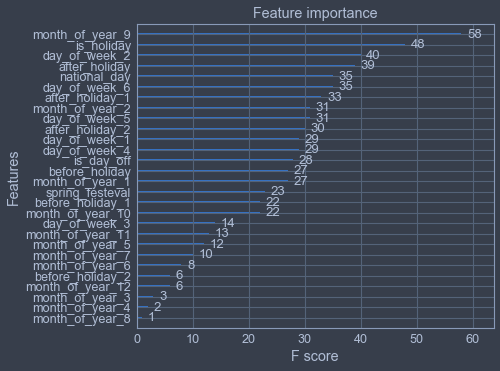

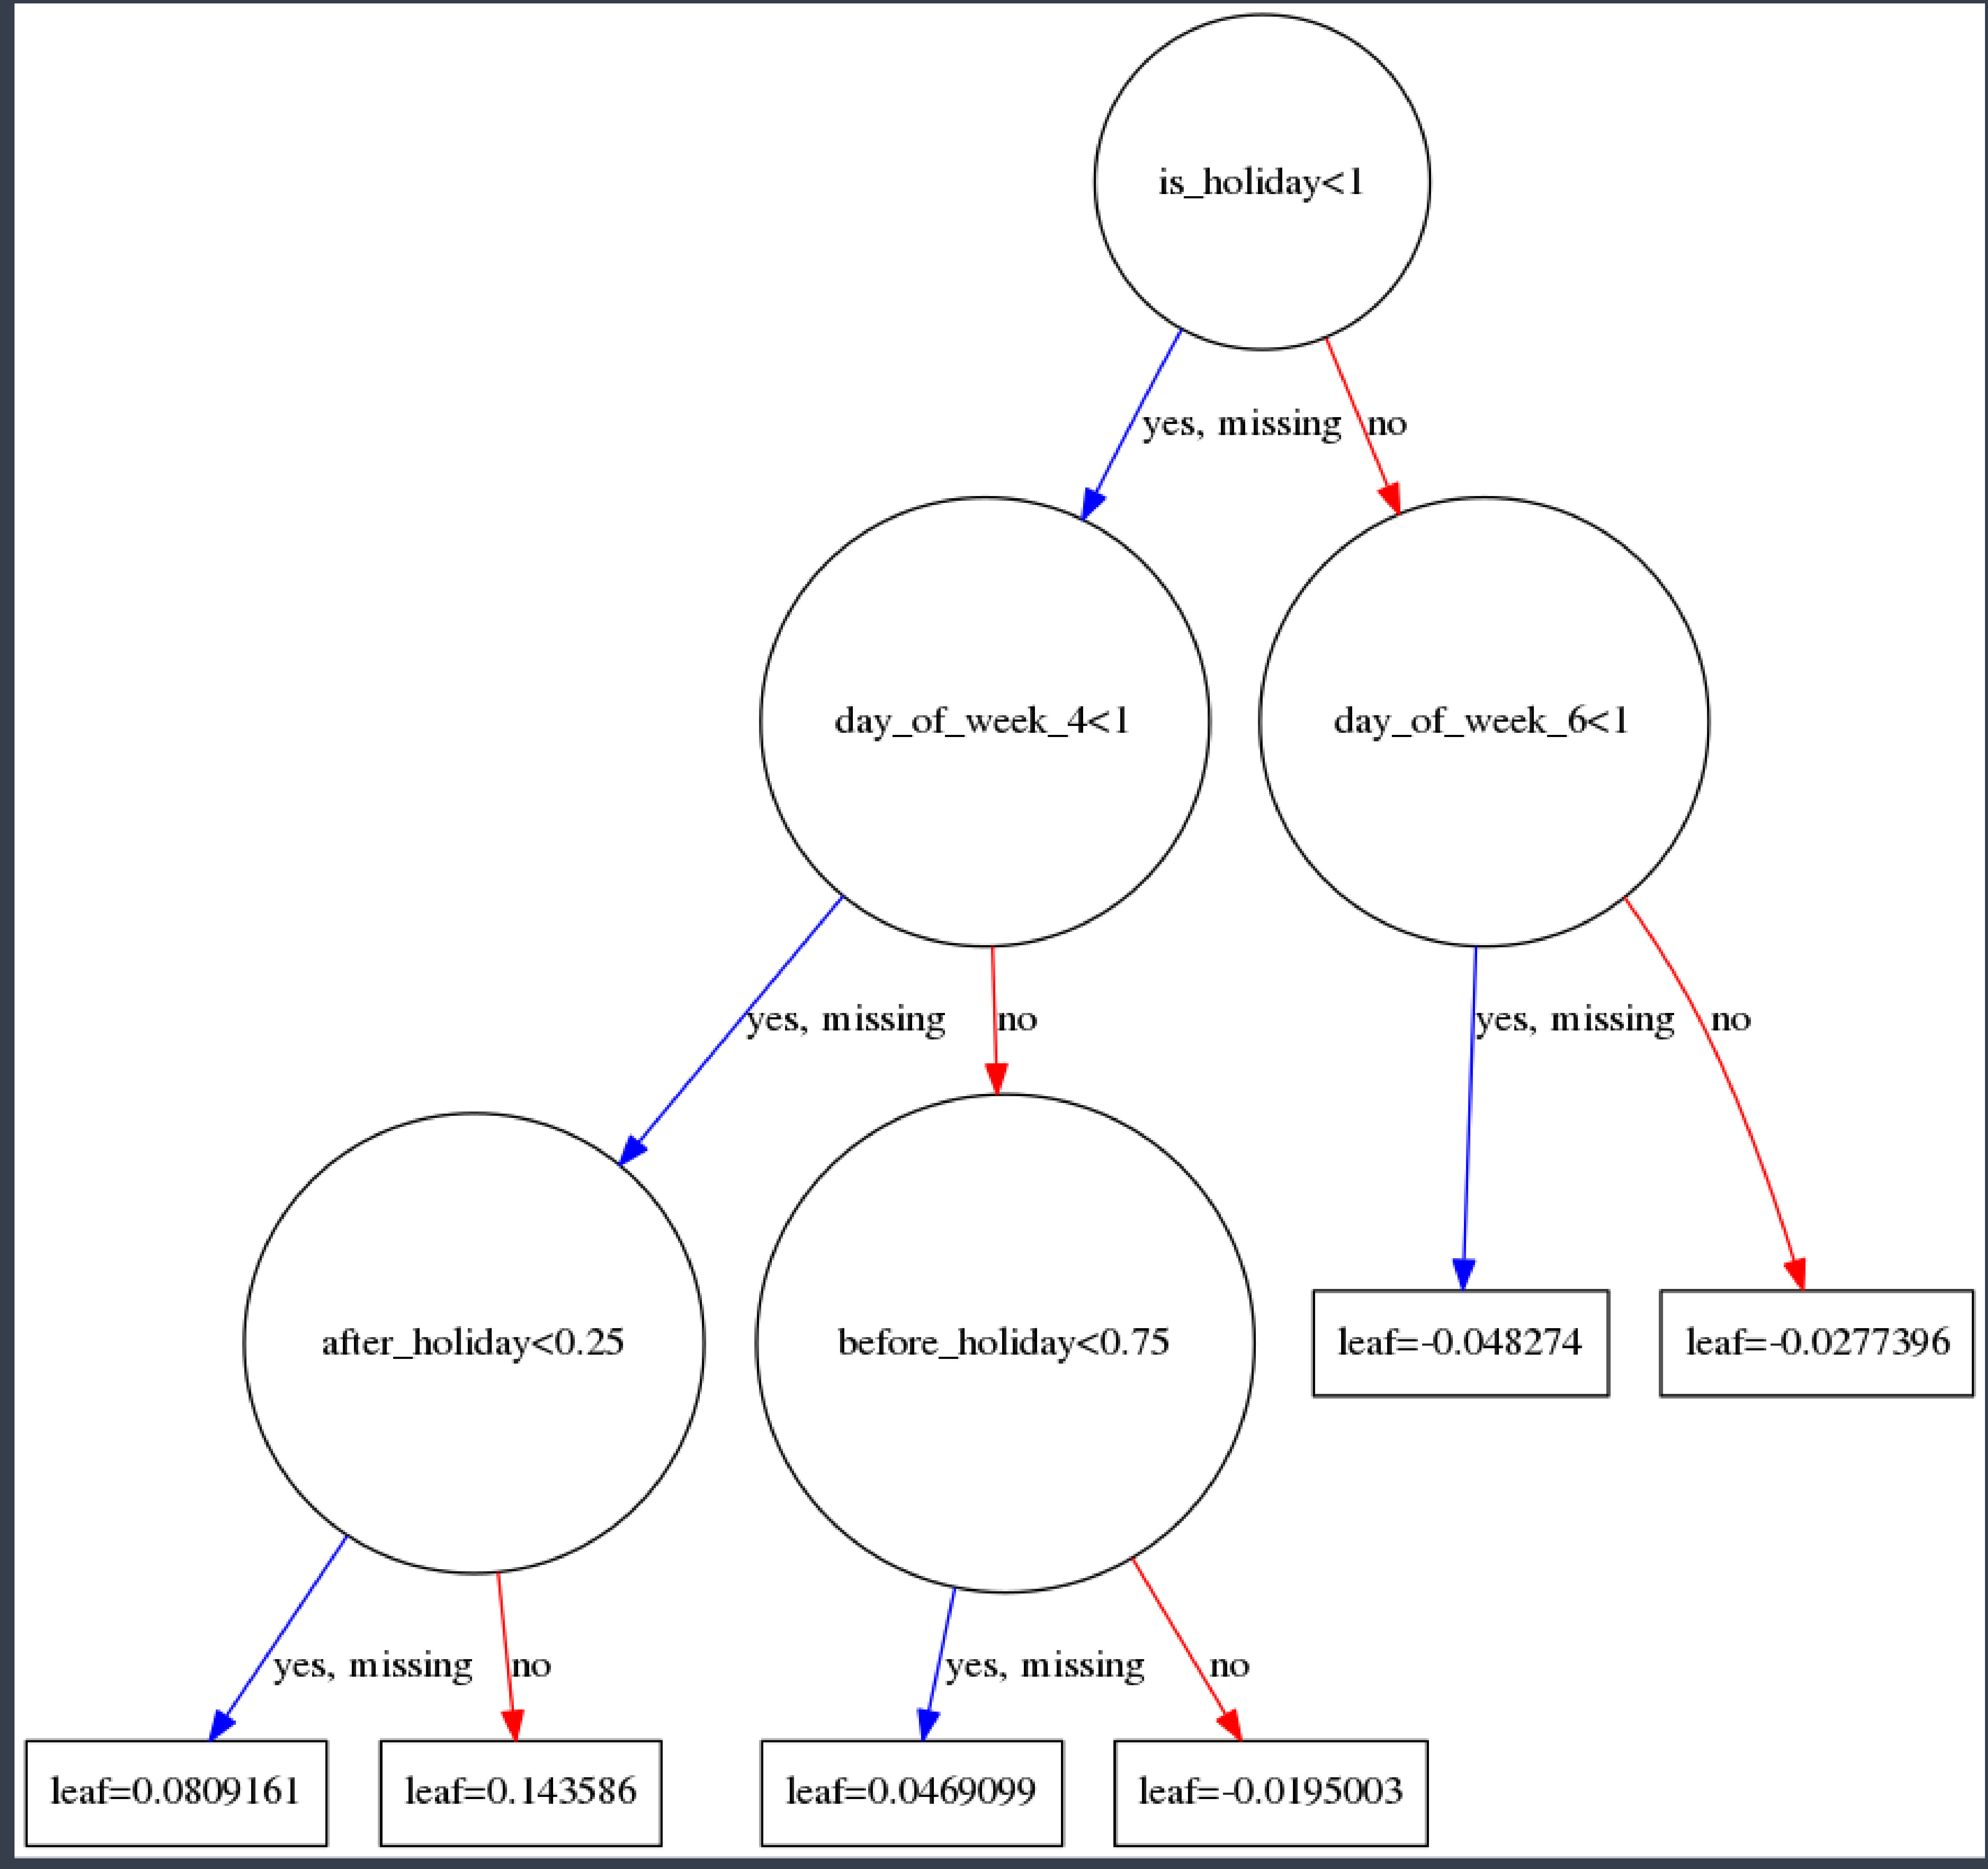

In [40]:
# 建立一个默认的xgboost回归模型
reg = xgboost.XGBRegressor(max_depth=max_depth)
reg.fit(train_X, train_y)
xgboost.plot_importance(reg)
xgboost.plot_tree(reg)
fig = plt.gcf()
fig.set_size_inches(120, 80)
#fig.savefig('tree.png')
# 验证
y_pred= reg.predict(valid_X)
frame = pd.Series(y_pred, index=valid_X.index)
frame.map(lambda x:x if x > 0 else 0)
frame.name = 'pred'
#pred_df = test_X.join(pred_y)
pred_df = train_fix_df.iloc[train_fix_df.index < '2014'].join(frame)

frame_days = pred_df.groupby('month').sum()['pred']
frame_days.name = 'month_days_pred'
pred_df = pred_df.join(frame_days, on='month')
#pred_df.loc[pred_df['month']=='2017-02-01', 'month_days'] = 14

print "MSE:", mean_squared_error(valid_y * pred_df['month_mean'], frame * pred_df['month_mean'])
print "MSE:", mean_squared_error(valid_y * pred_df['month_mean'] * pred_df['month_days'] / pred_df['month_days_pred'], frame * pred_df['month_mean'])

In [41]:
# train weight
reg1 = xgboost.XGBRegressor(max_depth=max_depth)
reg1.fit(train_X.iloc[train_X.index<'2015'], train_y.iloc[train_y.index<'2015'])

reg2 = xgboost.XGBRegressor(max_depth=max_depth)
reg2.fit(train_X.iloc[train_X.index>='2015'], train_y.iloc[train_y.index>='2015'])

y_pred1 = reg1.predict(valid_X)
y_pred2 = reg2.predict(valid_X)
y_pred = y_pred1 * 1 / 3 + y_pred2 * 2 / 3
frame = pd.Series(y_pred, index=valid_X.index)
frame.map(lambda x:x if x > 0 else 0)
frame.name = 'pred'
#pred_df = test_X.join(pred_y)
pred_df = train_fix_df.iloc[train_fix_df.index < '2014'].join(frame)

frame_days = pred_df.groupby('month').sum()['pred']
frame_days.name = 'month_days_pred'
pred_df = pred_df.join(frame_days, on='month')
#pred_df.loc[pred_df['month']=='2017-02-01', 'month_days'] = 14

print "MSE:", mean_squared_error(valid_y * pred_df['month_mean'], frame * pred_df['month_mean'])
print "MSE:", mean_squared_error(valid_y * pred_df['month_mean'] * pred_df['month_days'] / pred_df['month_days_pred'], frame * pred_df['month_mean'])

MSE: 331893.891529
MSE: 399871.682439


In [42]:
model = LinearRegression()
model.fit(train_X, train_y)
y_pred = model.predict(valid_X)

frame = pd.Series(y_pred, index=valid_X.index)
frame.map(lambda x:x if x > 0 else 0)
frame.name = 'pred'
#pred_df = test_X.join(pred_y)
pred_df = train_fix_df.iloc[train_fix_df.index < '2014'].join(frame)
print "MSE:", mean_squared_error(valid_y * pred_df['month_mean'], frame * pred_df['month_mean'])

#print pd.DataFrame(model.coef_, columns=train_X.columns.values)
print train_X.columns.values
print model.coef_

MSE: 353689.676642
['is_holiday' 'is_day_off' 'after_holiday' 'after_holiday_1'
 'after_holiday_2' 'before_holiday' 'before_holiday_1' 'before_holiday_2'
 'day_of_week_1' 'day_of_week_2' 'day_of_week_3' 'day_of_week_4'
 'day_of_week_5' 'day_of_week_6' 'day_of_week_7' 'month_of_year_1'
 'month_of_year_2' 'month_of_year_3' 'month_of_year_4' 'month_of_year_5'
 'month_of_year_6' 'month_of_year_7' 'month_of_year_8' 'month_of_year_9'
 'month_of_year_10' 'month_of_year_11' 'month_of_year_12' 'spring_festeval'
 'national_day']
[ -1.18230875e+00  -2.81924631e-01   7.07556639e-01   3.03929186e-02
   8.45480166e-02  -4.19125593e-01  -2.03531436e-01  -1.28587322e-01
   2.45405213e+12   2.45405213e+12   2.45405213e+12   2.45405213e+12
   2.45405213e+12   2.45405213e+12   2.45405213e+12  -1.11836905e+13
  -1.11836905e+13  -1.11836905e+13  -1.11836905e+13  -1.11836905e+13
  -1.11836905e+13  -1.11836905e+13  -1.11836905e+13  -1.11836905e+13
  -1.11836905e+13  -1.11836905e+13  -1.11836905e+13   3.14409

In [43]:
model = RandomForestRegressor(n_estimators=100)
model.fit(train_X, train_y)
y_pred = model.predict(valid_X)

frame = pd.Series(y_pred, index=valid_X.index)
frame.map(lambda x:x if x > 0 else 0)
frame.name = 'pred'
#pred_df = test_X.join(pred_y)
pred_df = train_fix_df.iloc[train_fix_df.index < '2014'].join(frame)
print "MSE:", mean_squared_error(valid_y * pred_df['month_mean'], frame * pred_df['month_mean'])

#print pd.DataFrame(model.coef_, columns=train_X.columns.values)
print train_X.columns.values
#print model.coef_

MSE: 398644.372447
['is_holiday' 'is_day_off' 'after_holiday' 'after_holiday_1'
 'after_holiday_2' 'before_holiday' 'before_holiday_1' 'before_holiday_2'
 'day_of_week_1' 'day_of_week_2' 'day_of_week_3' 'day_of_week_4'
 'day_of_week_5' 'day_of_week_6' 'day_of_week_7' 'month_of_year_1'
 'month_of_year_2' 'month_of_year_3' 'month_of_year_4' 'month_of_year_5'
 'month_of_year_6' 'month_of_year_7' 'month_of_year_8' 'month_of_year_9'
 'month_of_year_10' 'month_of_year_11' 'month_of_year_12' 'spring_festeval'
 'national_day']


In [44]:
# 预测
y_pred = reg.predict(test_X)
frame_pred = pd.Series(y_pred, index=test_X.index)
frame_pred.map(lambda x:x if x > 0 else 0)
frame_pred.name = 'pred'
#pred_df = test_X.join(pred_y)
pred_df = test_fix_df.join(frame_pred)

In [45]:
# 预测 weight
y_pred1 = reg1.predict(test_X)
y_pred2 = reg2.predict(test_X)
y_pred = y_pred1 * 1 / 3 + y_pred2 * 2 / 3
frame_pred = pd.Series(y_pred, index=test_X.index)
frame_pred.map(lambda x:x if x > 0 else 0)
frame_pred.name = 'pred'
#pred_df = test_X.join(pred_y)
pred_df = test_fix_df.join(frame_pred)

In [46]:
# 预测结果组合
frame = pred_ts
frame.name = 'month_mean'
pred_cb_df = pred_df.join(frame, on='month')

#print pred_cb_df.groupby('month').sum()['pred']
frame_days = pred_cb_df.loc[pred_cb_df['date']>0].groupby('month').sum()['pred']
frame_days.name = 'month_days_pred'
pred_cb_df = pred_cb_df.join(frame_days, on='month')

# pred_cb_df.loc[:, 'predict'] = pred_cb_df['month_mean'] * pred_cb_df['pred']
pred_cb_df.loc[:, 'predict'] = pred_cb_df['month_mean'] * pred_cb_df['pred'] * pred_cb_df['month_days'] / pred_cb_df['month_days_pred']
pred_cb_df.loc[:, 'predict'] = pred_cb_df['predict'].map(lambda x:x if x > 0 else 0)

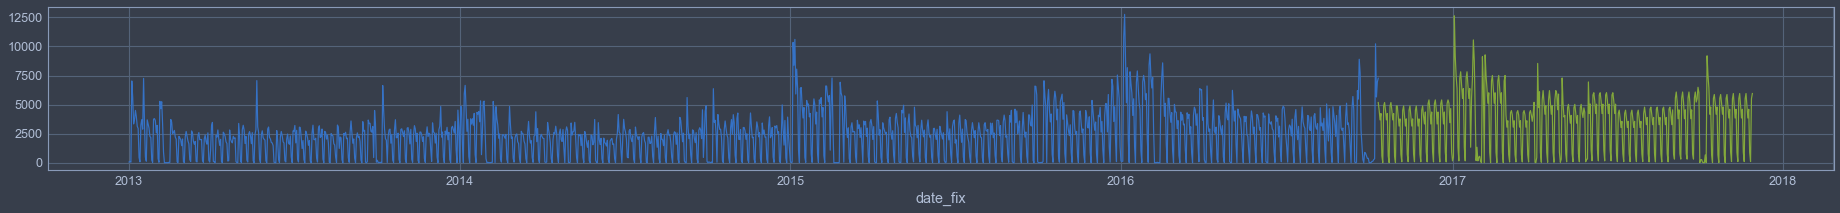

In [47]:
train_new_df.set_index('date_fix')['cnt'].plot(figsize=(32,3))
pred_cb_df['predict'].plot(figsize=(32,3))
pred_cb_df.loc[pred_cb_df['date']>0][['date', 'predict']].astype(int).to_csv('fs_temp.csv', sep='\t', index=False, header=False)
pred_cb_df[['date', 'day_of_week', 'predict']].to_csv('fs_temp_fix.csv')

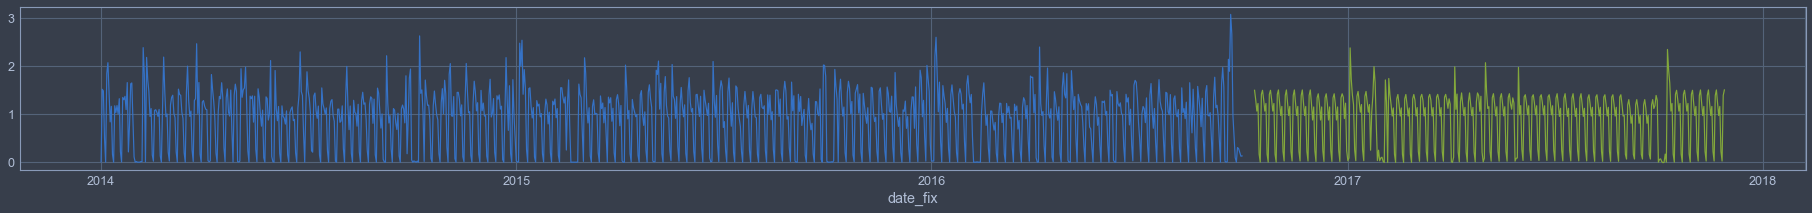

In [48]:
pred_cb_df[['month', 'month_days', 'month_days_pred']].drop_duplicates()
train_proc_df['day_factor'].plot(figsize=(32,3))
frame_pred.plot()

第二部，计算品牌数据

In [49]:
# predict by arima.ipynb
predict_fix_df = pd.read_csv('fs_temp_fix.csv')
predict_fix_df = predict_fix_df.rename(columns={'predict':'cnt'})

# convert to datetime
predict_fix_df.loc[:,'date_fix'] = pd.to_datetime(predict_fix_df['date_fix'])

# normalize
predict_fix_df.loc[:,'month'] = predict_fix_df.loc[:, 'date_fix'].map(lambda x: datetime(x.year,x.month,1))

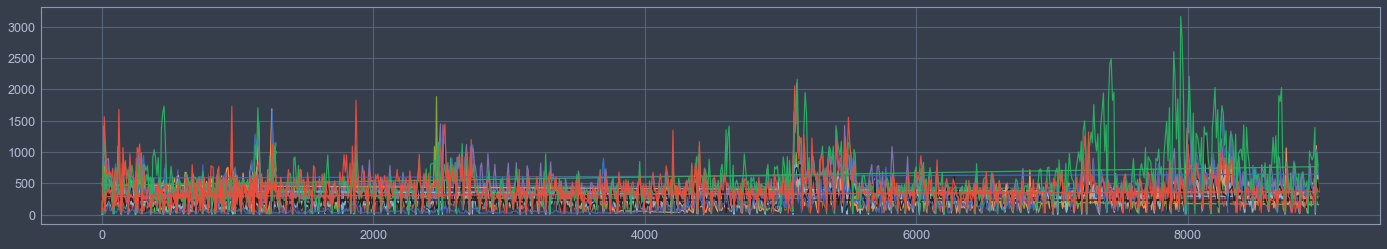

In [57]:
f = plt.figure(figsize=(24,4))
ax1 = f.add_subplot(111)
train_brand_df = train_df.groupby('brand', as_index=False)
for frame in train_brand_df:
    frame[1].loc[:,"cnt"].plot(ax = ax1)

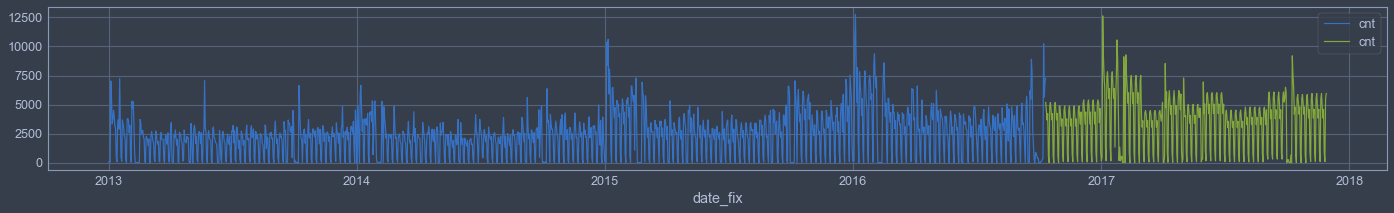

In [51]:
f = plt.figure(figsize=(24,3))
ax1 = f.add_subplot(111)
train_new_df[['date_fix', 'cnt']].set_index('date_fix').plot(ax=ax1)
predict_fix_df[['date_fix','cnt']].set_index('date_fix').plot(ax=ax1)

In [52]:
start_date = '2016-07-11'
end_date = '2016-10-12'
fs = train_new_df.loc[train_new_df['date_fix'] > start_date].sum()['cnt']

In [53]:
start_date_num = train_new_df.loc[train_new_df['date_fix'] == start_date]
start_date_num = start_date_num.iloc[0][0]
print start_date_num

brand_factors = train_df.loc[train_df['date'] > start_date_num].groupby('brand', as_index=False).sum()[['brand', 'cnt']]
brand_factors.loc[:,'factor'] = brand_factors.loc[:,'cnt'] / fs
brand_factors

1168


,brand,cnt,factor
0,1,21726,0.087214
1,2,17944,0.072032
2,3,19072,0.076560
3,4,24671,0.099036
4,5,33809,0.135719
5,6,19976,0.080189
6,7,22066,0.088579
7,8,33519,0.134554
8,9,33748,0.135474
9,10,22580,0.090642


In [54]:
# merge predict result 0225
# predict_base_df = train_fix_df.append(predict_fix_df.loc[predict_fix_df['date_fix'] > train_fix_df.iloc[-1,3]])
predict_base_df = predict_fix_df
# cnt
test_new_df.loc[:,'date_fix'] = test_new_df.loc[:,'date_fix'].astype(str)
predict_base_df.loc[:,'date_fix'] = predict_base_df.loc[:,'date_fix'].astype(str)
test_cnt_df = test_new_df.merge(predict_base_df[['date_fix', 'cnt']], how='left', on='date_fix')
test_cnt_df.loc[:, 'cnt'] = test_cnt_df.loc[:, 'cnt'] * factor
# brand cnt
test_ret_df = test_df.merge(test_cnt_df[['date', 'cnt', 'date_fix']], how='left', on='date')
test_ret_df = test_ret_df.merge(brand_factors[['brand', 'factor']], how='left', on='brand')
test_ret_df.loc[:, 'predict'] = test_ret_df.loc[:, 'cnt'] * test_ret_df.loc[:, 'factor'] 

In [55]:
test_ret_df.to_csv('fs_test_fix.csv')
test_ret_df[['date', 'brand', 'predict']].astype(int).to_csv('fs_test.csv', sep='\t', index=False, header=False)

In [56]:
testB_ret_df = test_ret_df.loc[test_ret_df['date'] >= 1250]

testB_ret_df.to_csv('fs_testB_fix.csv')
testB_ret_df[['date', 'brand', 'predict']].astype(int).to_csv('fs_testB.csv', sep='\t', index=False, header=False)